In [1]:
import sys
sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit

# Import et préparation des données

In [2]:
train = pd.read_csv("../data/application_train_vf.csv")
test = pd.read_csv("../data/application_test_vf.csv")

In [ ]:
dataprep = DataPreparation(train, test, 0.3, plot = True)
train_prepared, test_prepared = dataprep.get_prepared_data()

In [2]:
#train_prepared.to_csv("../data/train_prepared.csv")
#test_prepared.to_csv("../data/test_prepared.csv")
train_prepared = pd.read_csv("../data/train_prepared.csv", index_col=[0])
test_prepared = pd.read_csv("../data/test_prepared.csv", index_col=[0])

In [3]:
df_train = train_prepared.copy()

In [4]:
df_train["TARGET"] = df_train["TARGET"].astype("int")

In [5]:
df_validation = df_train.iloc[280000:,:]
df_train = df_train.iloc[:280000,:]

# Modélisation

In [6]:
features = list(df_train.iloc[:,2:4].columns)

In [7]:
formula = f'TARGET ~ {" + ".join(f"C({var})" for var in features)}'

In [8]:
reference_categories = {var : df_train[var].mode()[0] for var in features}

In [9]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')
    else:
        formula_parts.append(f'C({var})')  # Ou simplement 'var' si c'est une variable continue

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [10]:
model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit_regularized(maxiter = 500, method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2567339735493347
            Iterations: 39
            Function evaluations: 39
            Gradient evaluations: 39


# Prédiction

In [11]:
pred = logit_model.predict(df_validation[features])

In [12]:
pred = pred.apply(lambda x : 0 if x < 0.5 else 1)

/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


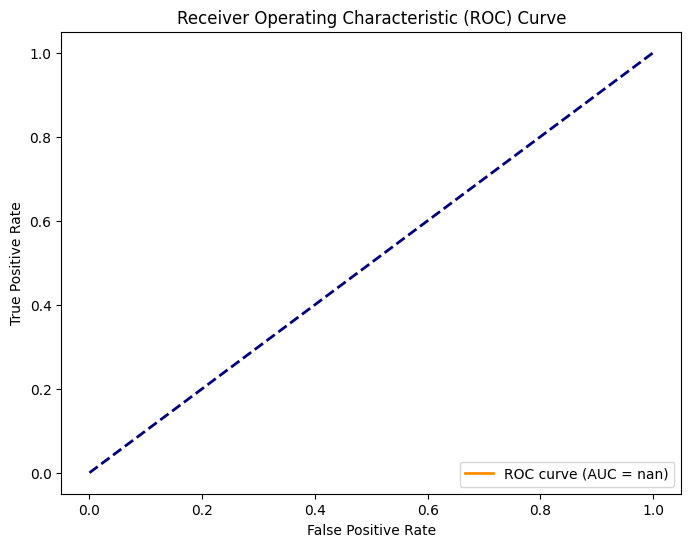

In [13]:
fpr, tpr, thresholds = roc_curve(pred, df_validation["TARGET"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [14]:
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

nan

# Grille de score

In [16]:
g = GridScore(train_prepared, logit_model).compute_grid_score()

In [17]:
g

,Variable,Modality,Coefficient,P-Value,Score,Pcentage_Défaut,Pcentage_Classe
0,Intercept,-,-2.879932,0.0,0.000000,0.00,0.00
1,DAYS_BIRTH_disc_int,[-18807;-13580]_ref,0.000000,0.0,114.285714,2.68,36.16
2,DAYS_BIRTH_disc_int,[-13579;-7489],0.240000,0.0,0.000000,3.37,33.31
3,DAYS_BIRTH_disc_int,[-25229;-18808],-0.400000,0.0,304.761905,1.61,30.53
4,EXT_SOURCE_2_disc_int,[0.48;0.85]_ref,0.000000,0.0,695.238095,3.44,65.31
5,EXT_SOURCE_2_disc_int,[0.0;0.16],1.460000,0.0,0.000000,1.25,6.23
6,EXT_SOURCE_2_disc_int,[0.16;0.48],0.720000,0.0,352.380952,2.98,28.45


## Calcul des scores individuels

In [69]:
score_dict = {}
for index, row in g.iterrows():
    var = row["Variable"]
    mod = row["Modality"].split("_ref")[0]
    score = row["Score"]
    
    if var not in score_dict:
        score_dict[var] = {}
    score_dict[var][mod] = score

In [70]:
def compute_score(row, features):
    score = 0
    for var in features :
        modality = row[var]
        score += score_dict[var][modality]
    return(score)

In [71]:
def compute_individual_score(df, features):
    df_score = df.copy()
    df_score["Score_ind"] = 0
    df_score["Score_ind"] = df_score.apply(lambda row : compute_score(row, features), axis = 1)
    return(df_score)

In [50]:
df2 = compute_individual_score(train_prepared, features)